# Financial News Sentiment Analysis
Classify the sentiment of financial news headlines as positive, neutral, or negative using classical machine learning and neural network methods.

## Setup

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import spacy
import seaborn as sns
from typing import List, Tuple
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
from collections import Counter
from wordcloud import WordCloud
import string 
pd.set_option('display.max_colwidth',200)

## Load Dataset:
The dataset used is the **Financial Phrase Bank v1.0**, created by researchers at Aalto University. It contains 4846 financial and economic news sentences annotated for sentiment. This project specifically uses the **Sentences_50Agree.txt** file, which includes sentences where **at least 50% of annotators** agreed on the sentiment label.

In [5]:
def load_data(data_path: str, text_column: str, sentiment_col: str) -> pd.DataFrame:
    """Load data from a text file where each line contains text and label separated by '@'.
    Lines without the delimiter are skipped."""
    data = []
    skipped = 0
    print(f"Loading data from: {data_path} ...")
    with open(data_path, "r", encoding="latin1") as f:
        for line in f:
            line = line.strip()
            if "@" not in line:
                skipped += 1
                continue
            parts = line.split("@", 1)  # split only on first '@'
            data.append(parts)

    print(f"Loaded {len(data)} lines.")
    print(f"Skipped {skipped} lines without labels.")
    return pd.DataFrame(data, columns=[text_column, sentiment_col])


In [6]:
data_path = "../data/Sentences_50Agree.txt"
text_col = "news"
sentiment_col = "sentiment"
%time
corpora = load_data(data_path=data_path, text_column=text_col, sentiment_col=sentiment_col)

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 2.15 μs
Loading data from: ../data/Sentences_50Agree.txt ...
Loaded 4846 lines.
Skipped 0 lines without labels.


In [7]:
corpora.head()

,news,sentiment
0,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .",neutral
1,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .",neutral
2,The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers ...,negative
3,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profi...,positive
4,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net ...",positive


## Extract insights from data
In this task, we explore and analyze the dataset to better understand its structure and content before model development.

In [9]:
corpora.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   news       4846 non-null   object
 1   sentiment  4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [10]:
corpora.isna().sum()

news         0
sentiment    0
dtype: int64

No missing values exist in the dataset.

### Basic Text Preprocessing

Before conducting statistical analysis on the text data, basic preprocessing was applied to each sentence:

All text was converted to lowercase

Punctuation marks were removed

English stopwords (e.g., "the", "and", "in") were filtered out

This ensures that only meaningful, content-heavy words contribute to the vocabulary statistics and visualizations such as word frequency and word clouds.

In [13]:
def clean_text(text) -> str:
    """Lowercases text, removes punctuation and stopwords."""
    stop_words = set(stopwords.words("english"))
    punct_table = str.maketrans("", "", string.punctuation)

    if not isinstance(text, str):
        return ""
    text = text.lower().translate(punct_table)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [14]:
clean_column = f"clean_{text_col}"
corpora[clean_column] = corpora[text_col].apply(clean_text)
corpora = corpora[[text_col, clean_column, sentiment_col]]
corpora.sample(5)

,news,clean_news,sentiment
3352,The secondary antenna can also be used for reception of the high power signal of the radar to calibrate the transmission channels of the radar . '',secondary antenna also used reception high power signal radar calibrate transmission channels radar,neutral
3616,"In 2007 , the Group 's net sales stood at EUR 42 million and it had about 1,445 employees .",2007 group net sales stood eur 42 million 1445 employees,neutral
4313,Finnish bank Alandsbanken said Monday it will buy the Swedish operations of Iceland 's troubled Kaupthing Bank for 414 million kronor $ 49.5 million in cash .,finnish bank alandsbanken said monday buy swedish operations iceland troubled kaupthing bank 414 million kronor 495 million cash,neutral
4126,Possible personnel reductions concern approximately 104 people .,possible personnel reductions concern approximately 104 people,negative
4567,"Making matters more difficult , the company said it has been grappling with higher oil and gas prices , which have pushed up the cost of energy , raw materials and transportation .",making matters difficult company said grappling higher oil gas prices pushed cost energy raw materials transportation,negative


### Sentiment Class Distribution

In [16]:
label_counts = corpora[sentiment_col].value_counts()
label_percent = round((label_counts / label_counts.sum()) * 100, 2)
for label in label_counts.index:
    print(f"{label:<10}: {label_counts[label]} sentences ({label_percent[label]}%)")

neutral   : 2879 sentences (59.41%)
positive  : 1363 sentences (28.13%)
negative  : 604 sentences (12.46%)


Most sentences are labeled as neutral. There are fewer positive and even fewer negative sentences. This means the data is not evenly split between the three types, so we should be careful when training models so they don't just learn to guess "neutral" most of the time.

In [18]:
color_map = {
    "positive": "green",
    "negative": "red",
    "neutral": "gray",
}
def plot_data_distribution_by_sentiment(df, sentiment_col, save=False, save_path=""):
    """Plot the distribution of data across different sentiment classes."""
    counts = df[sentiment_col].value_counts()
    total = counts.sum()
    colors = [color_map.get(label, "gray") for label in counts.index]
    
    plt.figure(figsize=(10, 7))
    ax = counts.plot.bar(
        xlabel="Sentiment",
        ylabel="Number of Samples",
        color=colors,
        title="Data Distribution by Sentiment",
    )
    for i, (label, count) in enumerate(counts.items()):
        percentage = count / total * 100
        ax.text(i, count + total * 0.01, f"{count} ({percentage:.2f}%)", ha='center', fontsize=9)
    if save and save_path:
        plt.savefig(f"{save_path}/sentiment_distribution.png", bbox_inches="tight")
    plt.show()
    plt.close()

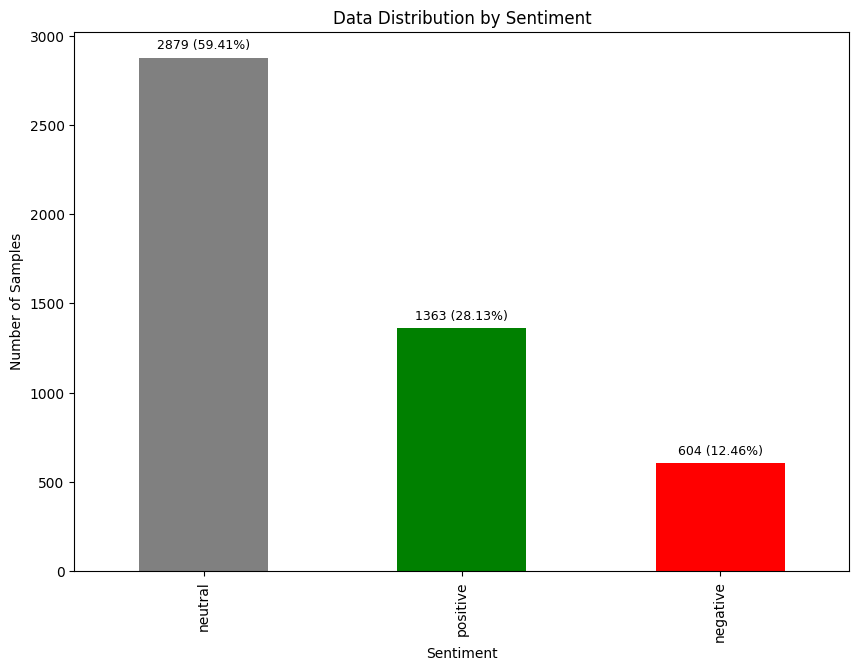

In [19]:
save_path = "../reports/insights"
plot_data_distribution_by_sentiment(df=corpora, sentiment_col=sentiment_col, save=True , save_path=save_path)

### Text Length Analysis
We checked how many words are in each sentence, before and after basic cleaning (like lowercase, removing stopwords and punctuation).

**Before cleaning the text:**

- The average sentence had 23 words.

- The shortest had 2 words, and the longest had 81.

- About 50% of the sentences had between 16 and 29 words.

- About 25% of the sentences had less than 16 words (roughly 1211 sentences)

- Another 25% had more than 29 words (also around 1211 sentences)

**After simple text cleaning:**

- The average dropped to 13 words, since common words like "the", "in", and "of" were removed

- Most sentences had between 9 and 17 words

- The shortest had 0 words (after removing stopwords), the longest had 47

- The cleaned sentences ranged from 0 to 47 words

This shows that removing stopwords and punctuation greatly reduces sentence length and keeps only the more meaningful words.

In [21]:
def count_number_of_words(df: pd.DataFrame, column_to_count: str, count_to: str = "number_of_words") -> pd.DataFrame:
    df[count_to] = df[column_to_count].apply(lambda x: len(x.split()))
    return df

In [34]:
corpora = count_number_of_words(df=corpora,column_to_count=text_col, count_to="number_of_words_before_preprocessing")
corpora = count_number_of_words(df=corpora,column_to_count=clean_column, count_to="number_of_words_after_simple_preprocessing")
corpora = corpora[[text_col, clean_column, "number_of_words_before_preprocessing", "number_of_words_after_simple_preprocessing", sentiment_col, ]]
corpora.head(5)

,news,clean_news,number_of_words_before_preprocessing,number_of_words_after_simple_preprocessing,sentiment
0,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .",according gran company plans move production russia although company growing,25,10,neutral
1,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .",technopolis plans develop stages area less 100000 square meters order host companies working computer technologies telecommunications statement said,31,18,neutral
2,The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers ...,international electronic industry company elcoteq laid tens employees tallinn facility contrary earlier layoffs company contracted ranks office workers daily postimees reported,36,21,negative
3,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profi...,new production plant company would increase capacity meet expected increase demand would improve use raw materials therefore increase production profitability,33,20,positive
4,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net ...",according company updated strategy years 20092012 basware targets longterm net sales growth range 20 40 operating profit margin 10 20 net sales,41,22,positive


In [36]:
corpora["number_of_words_before_preprocessing"].describe().round(2)

count    4846.00
mean       23.10
std         9.96
min         2.00
25%        16.00
50%        21.00
75%        29.00
max        81.00
Name: number_of_words_before_preprocessing, dtype: float64

In [38]:
corpora["number_of_words_after_simple_preprocessing"].describe().round(2)

count    4846.00
mean       13.20
std         6.27
min         0.00
25%         9.00
50%        12.00
75%        17.00
max        47.00
Name: number_of_words_after_simple_preprocessing, dtype: float64

In [40]:
def plot_word_count_distribution_by_sentiment(df, text_length_col, sentiment_col, save=False, save_path=""):
    """Plot the distribution of word counts across different sentiment classes."""
    unique_sentiments = df[sentiment_col].unique()
    for sentiment in unique_sentiments:
        sentiment_subset = df[df[sentiment_col] == sentiment]
        plt.hist(
            sentiment_subset[text_length_col], alpha=0.5, label=str(sentiment), bins=15
        )
    plt.legend()
    plt.xlabel("Text Length")
    plt.ylabel("Frequency")
    plt.title("Text Length Distribution Across Sentiments")
    if save and save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    plt.close()

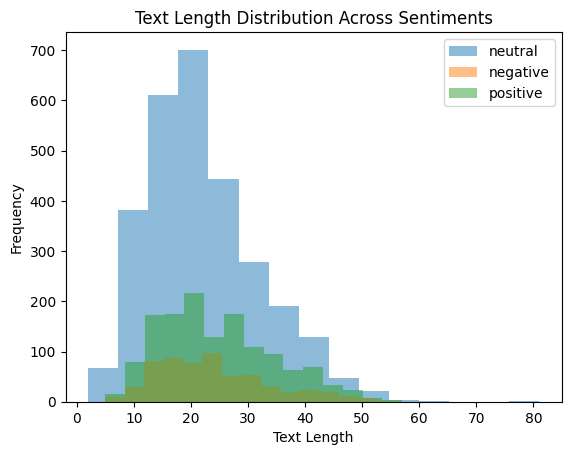

In [42]:
save_as = f"{save_path}/word_count_distribution_before.png"
plot_word_count_distribution_by_sentiment(corpora, "number_of_words_before_preprocessing", sentiment_col, True, save_as)

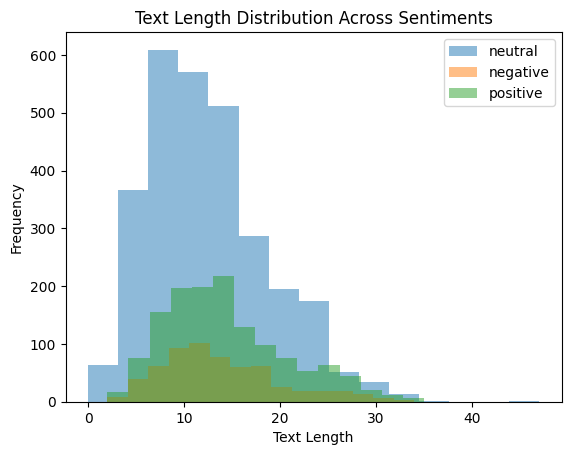

In [44]:
save_as = f"{save_path}/word_count_distribution_after.png"
plot_word_count_distribution_by_sentiment(corpora, "number_of_words_after_simple_preprocessing", sentiment_col, True, save_as)

### Average Text Length by Sentiment

In [46]:
def plot_avg_word_count_by_sentiment(df, text_length_col, sentiment_col, save=False, save_path=""):
    """Plot the average text length (in words) for each sentiment class."""
    group_avg = df.groupby(sentiment_col)[text_length_col].mean()
    colors = [color_map.get(label, "gray") for label in group_avg.index]
     
    plt.figure(figsize=(9, 6))
    ax = group_avg.plot.bar(color=colors, title="Average Text Length by Sentiment")

    for i, value in enumerate(group_avg):
        ax.text(i, value + 0.1, f"{value:.2f}", ha='center', va='bottom')
    plt.ylabel("Average Text Length (Number of Words)")
    plt.xlabel("Sentiment")
    if save and save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    plt.close()

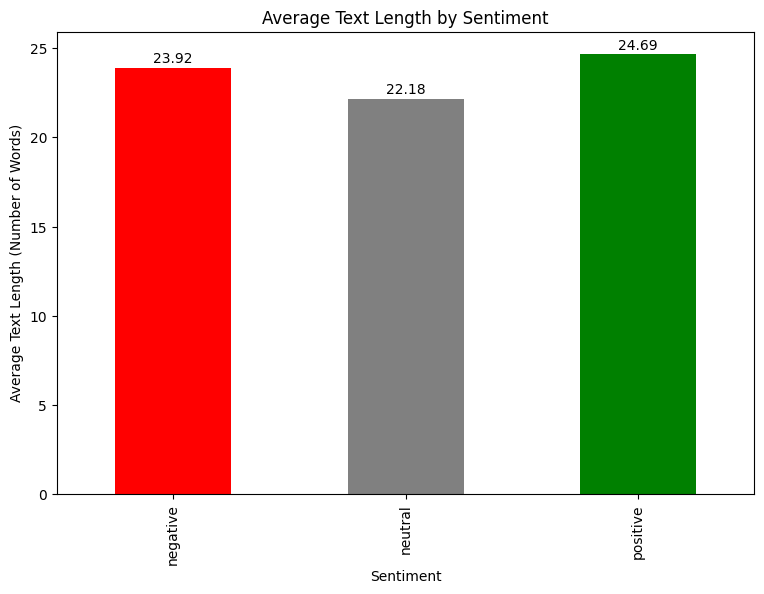

In [49]:
save_as = f"{save_path}/avg_word_count_before.png"
plot_avg_word_count_by_sentiment(corpora, "number_of_words_before_preprocessing", sentiment_col, True, save_as)

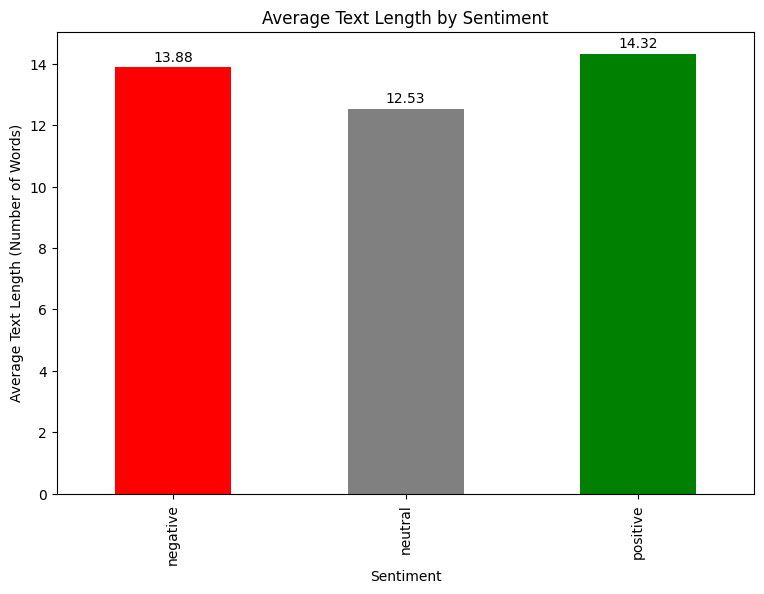

In [51]:
save_as = f"{save_path}/avg_word_count_after.png"
plot_avg_word_count_by_sentiment(corpora, "number_of_words_after_simple_preprocessing", sentiment_col, True, save_as)

### Vocabulary Size Comparison

We calculate the number of unique words in each sentiment class before and after cleaning.

In [54]:
def get_unique_words(texts):
    """Return a set of unique words from a list/series of texts."""
    all_words = " ".join(texts).split()
    return set(all_words)
    
def plot_unique_words_by_sentiment(df, text_column, sentiment_col, save=False, save_path=""):
    """Plot the number of unique words used in texts for each sentiment class,
    and draw a horizontal line representing the total number of unique words across all classes."""
    sentiments = df[sentiment_col].unique()
    unique_counts = {
        sentiment: len(
            get_unique_words(df[df[sentiment_col] == sentiment][text_column])
        )
        for sentiment in sentiments
    }

    for sentiment, count in unique_counts.items():
        print(f"Unique words in sentiment '{sentiment}': {count}")

    total_unique = len(get_unique_words(df[text_column]))
    print("Total unique words across all sentiments:", total_unique)

    colors = [color_map.get(sentiment, "gray") for sentiment in unique_counts.keys()]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(unique_counts.keys(), unique_counts.values(), color=colors)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 5, str(height), ha='center', va='bottom')
    plt.axhline(y=total_unique, color="black", linestyle="--")
    plt.text(len(unique_counts) / 2 - 0.5, total_unique + 5, f"{total_unique}", ha='center', va='bottom', color='black')

    legend_elements = [
        Patch(facecolor=color_map.get(sentiment, "gray"), label=f"{sentiment}")
        for sentiment in unique_counts.keys()
    ]
    legend_elements.append(Patch(facecolor="black", label="Total Unique Words"))

    plt.legend(handles=legend_elements)
    plt.title("Number of Unique Words in each Sentiment Class")
    plt.ylabel("Number of Unique Words")
    plt.xlabel("Sentiment")
    if save and save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    plt.close()

Unique words in sentiment 'neutral': 9686
Unique words in sentiment 'negative': 2870
Unique words in sentiment 'positive': 5742
Total unique words across all sentiments: 12971


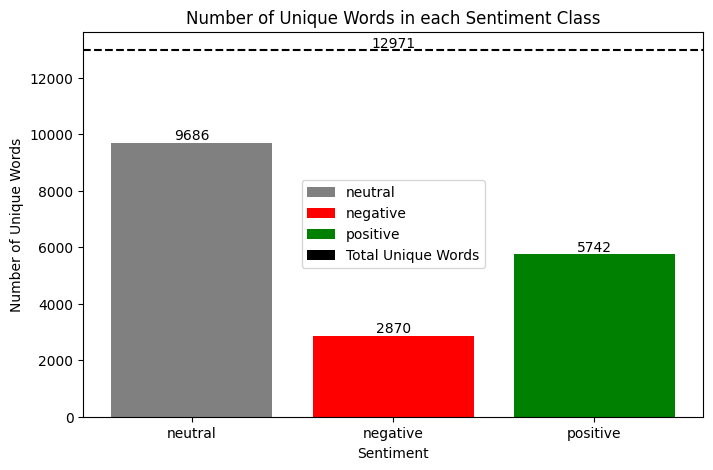

In [56]:
save_as = f"{save_path}/unique_words_before.png"
plot_unique_words_by_sentiment(corpora, text_col, sentiment_col, True, save_as)

Unique words in sentiment 'neutral': 8358
Unique words in sentiment 'negative': 2501
Unique words in sentiment 'positive': 5005
Total unique words across all sentiments: 11135


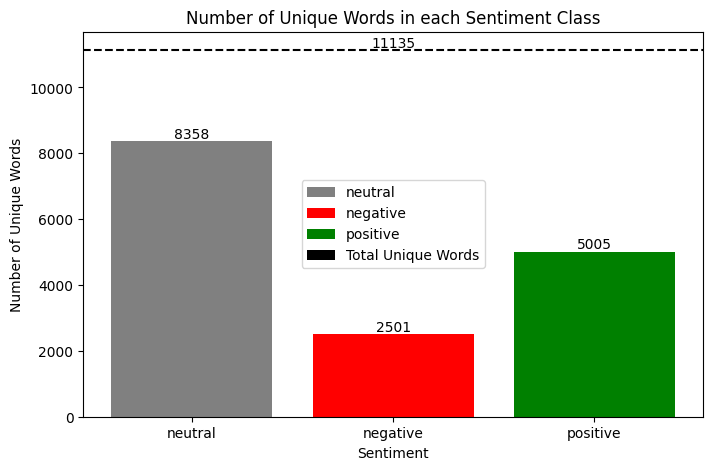

In [58]:
save_as = f"{save_path}/unique_words_after.png"
plot_unique_words_by_sentiment(corpora, clean_column, sentiment_col, True, save_as)

### Common Vocabulary Across Sentiment Classe
The most common words in each type of financial news headline

In [61]:
def plot_most_common_words_by_sentiment(df, text_column, sentiment_col, top_n=30, save=False, save_path=""):
    """Plot the most common words in each sentiment class as a bar chart."""
    sentiments = df[sentiment_col].unique()
    fig = plt.figure(figsize=(20, 12))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

    axes = []
    for i in range(len(sentiments)):
        if i < 2:
            ax = fig.add_subplot(gs[0, i])
        else:
            ax = fig.add_subplot(gs[1, :])
        axes.append(ax)

    for i, sentiment in enumerate(sentiments):
        words = " ".join(df[df[sentiment_col] == sentiment][text_column]).split()
        common = Counter(words).most_common(top_n)
        words_, counts = zip(*common)

        color = color_map.get(sentiment, "gray")
        axes[i].bar(words_, counts, color=color)
        axes[i].set_title(
            f"Top {top_n} Words in {sentiment.capitalize()} Financial News", fontsize=24
        )
        axes[i].set_xlabel("Words")
        axes[i].set_ylabel("Frequency")
        axes[i].tick_params(axis="x", labelrotation=60)

    plt.tight_layout()
    if save and save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    plt.close()

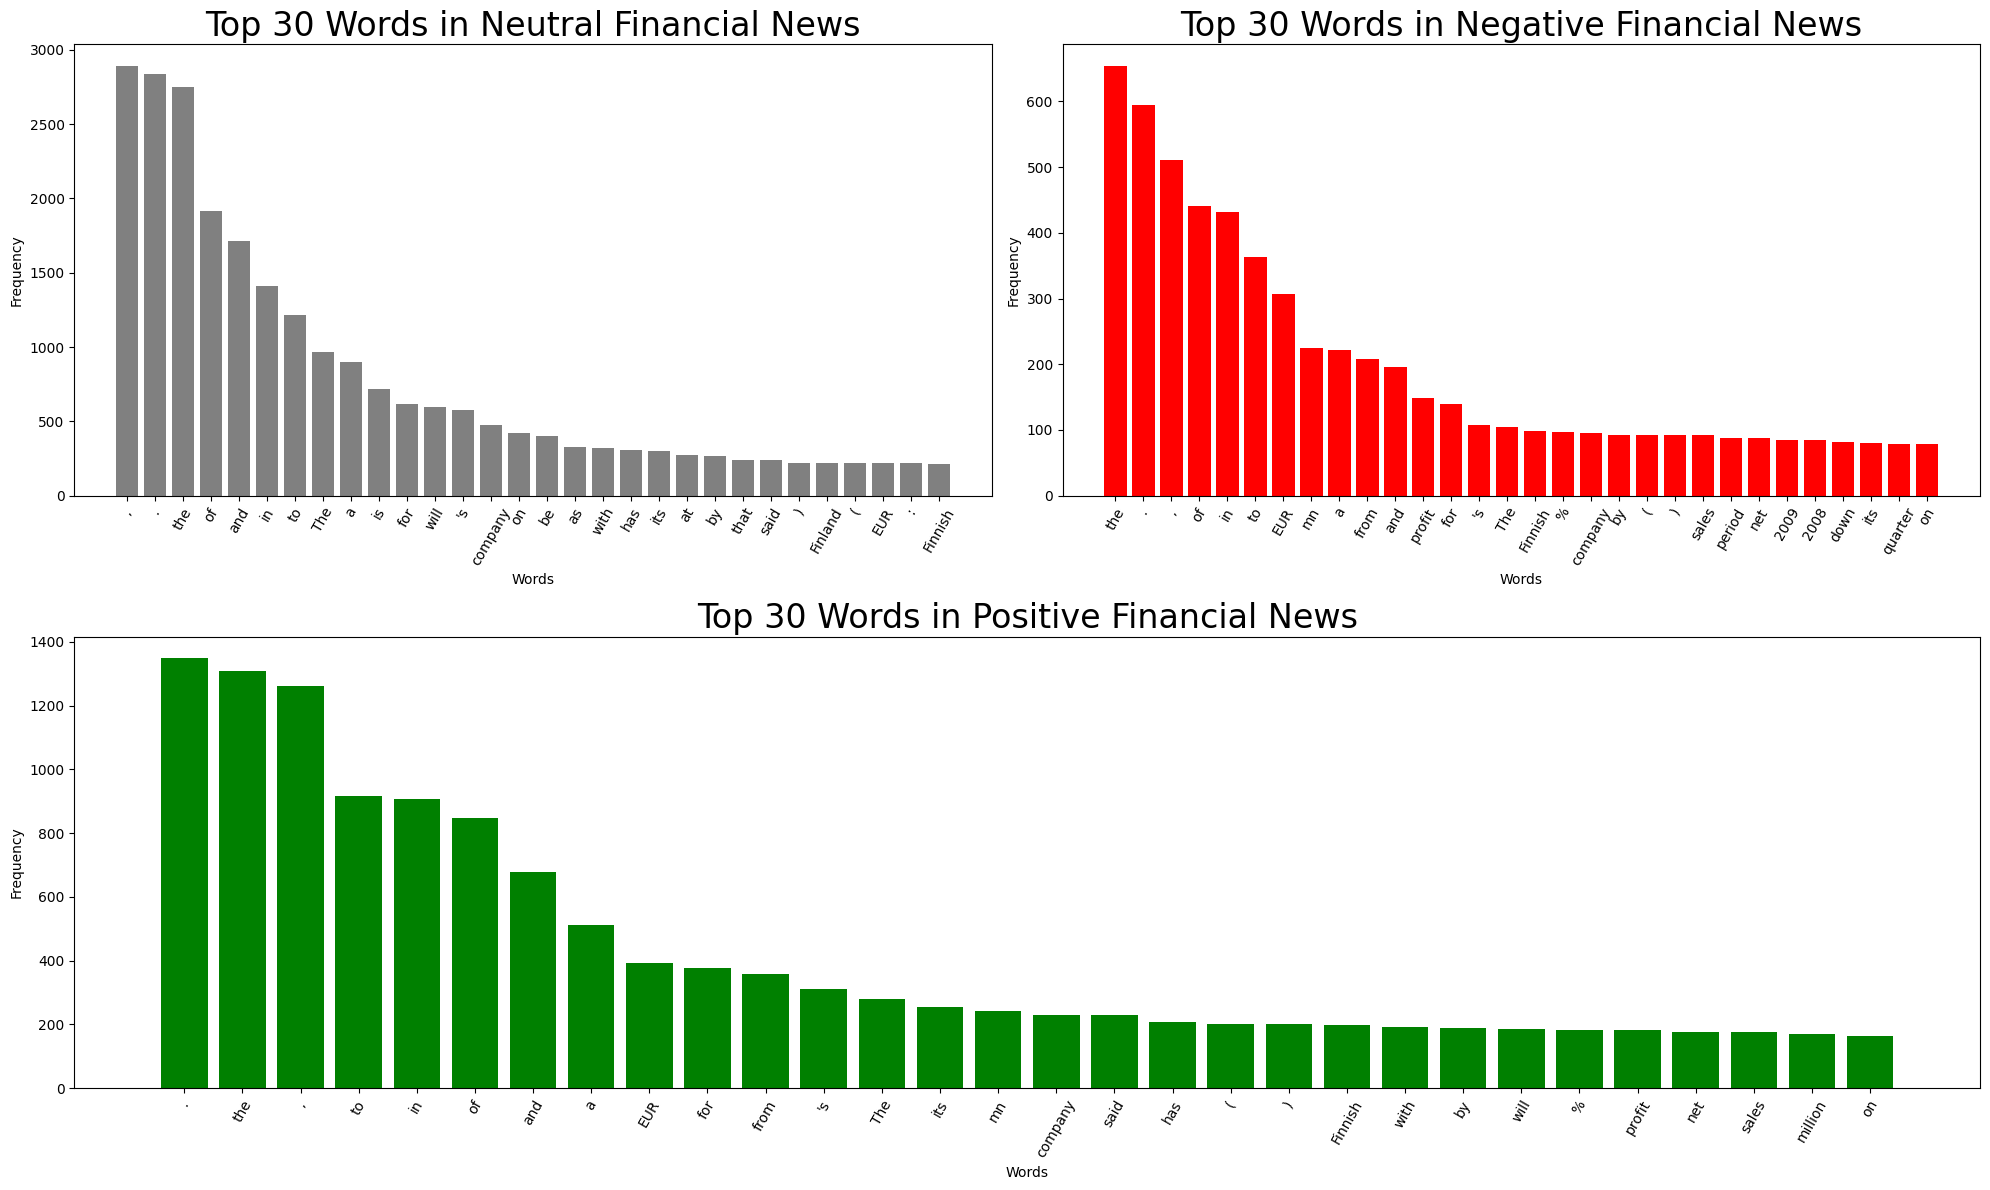

In [63]:
save_as = f"{save_path}/most_common_words_before.png"
plot_most_common_words_by_sentiment(df=corpora, text_column=text_col, sentiment_col=sentiment_col, save=True, save_path=save_as)

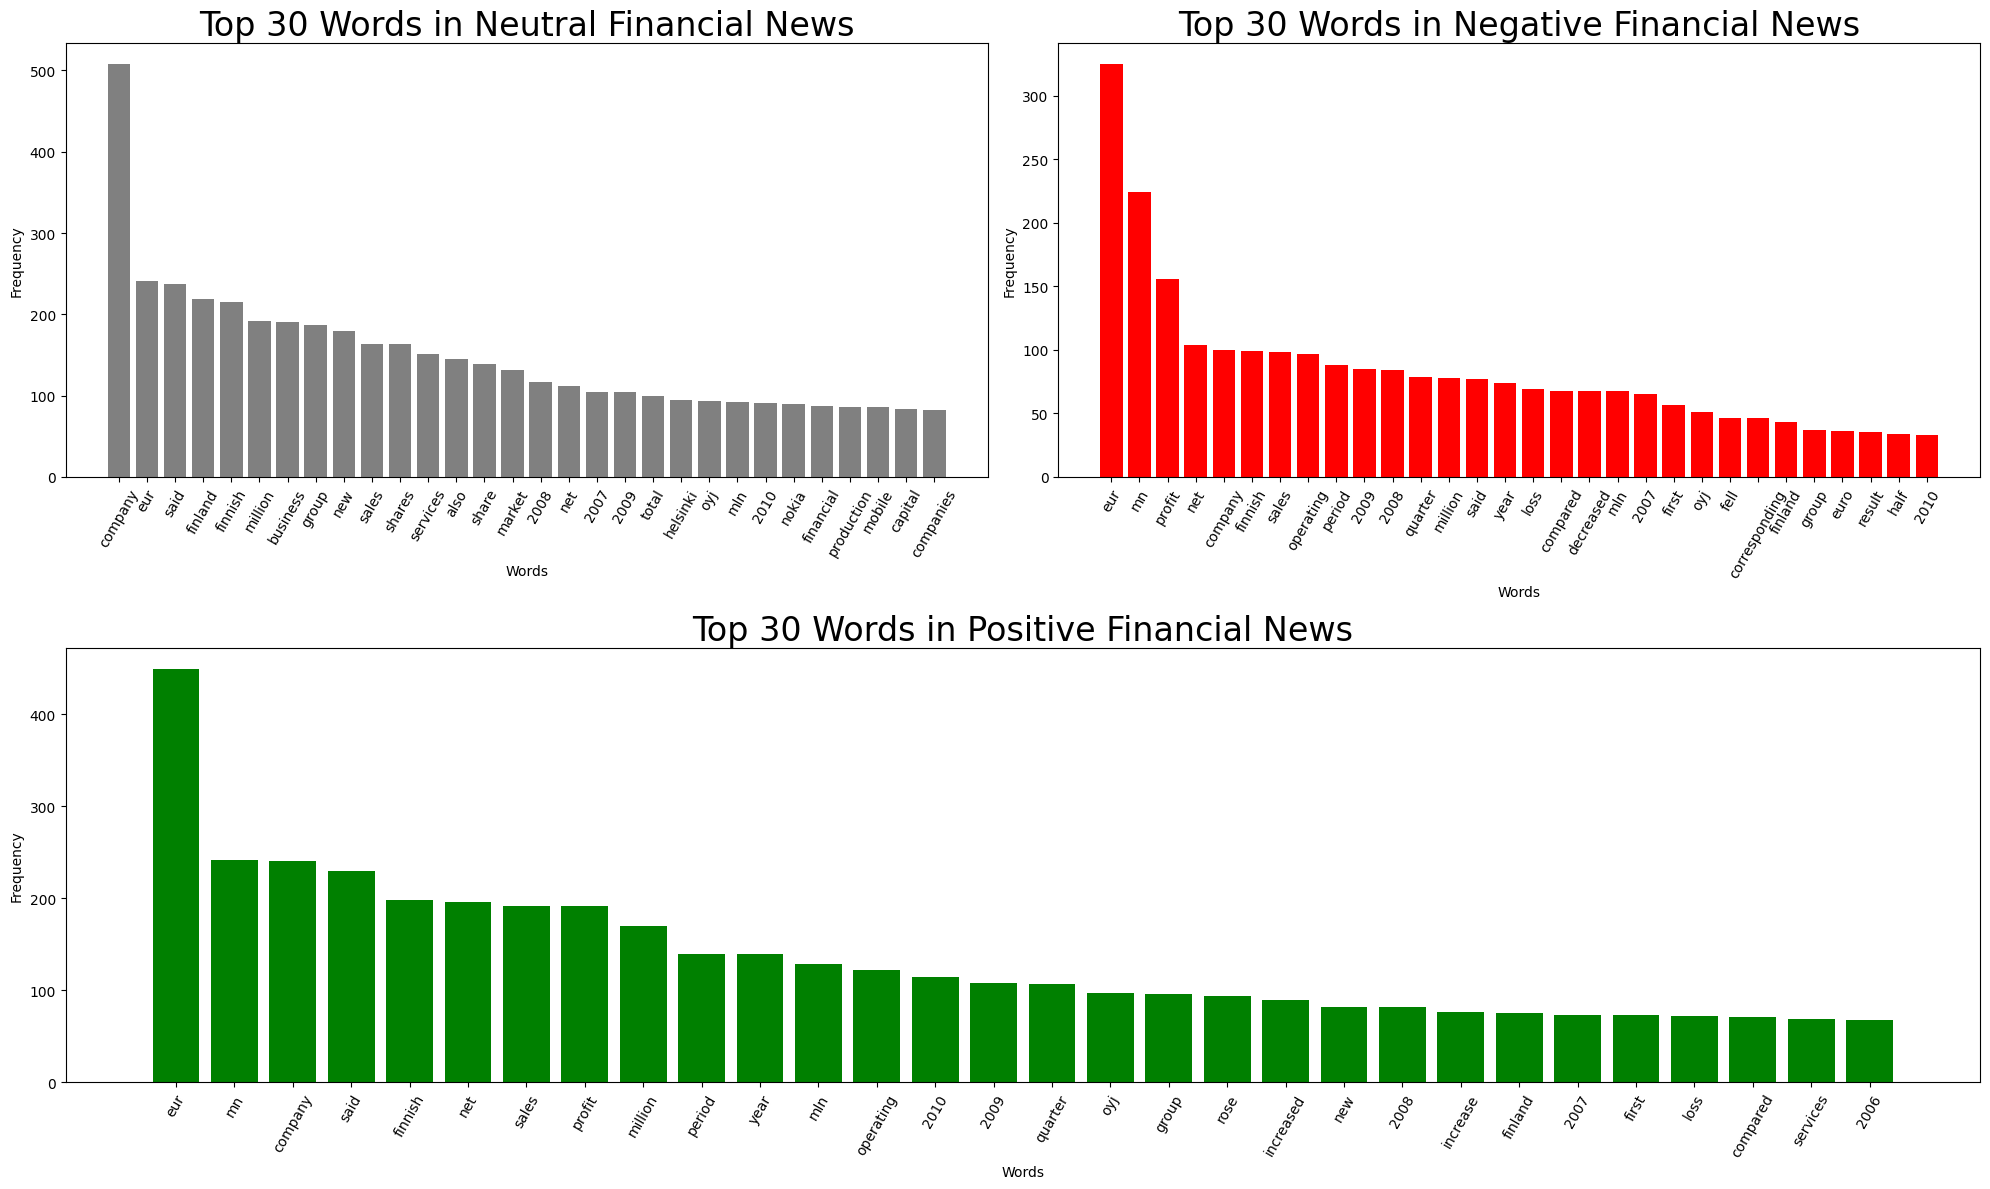

In [64]:
save_as = f"{save_path}/most_common_words_after.png"
plot_most_common_words_by_sentiment(df=corpora, text_column=clean_column, sentiment_col=sentiment_col, save=True, save_path=save_as)

### Word Cloud for each Sentiment Class
We looked at the most common words in each type of financial news headline. This gives a better idea of what each group focuses on:

- **Neutral News**
Top words:

- company, eur, said, finland, finnish, million, business, group, new, sales

These words are general and related to company updates, regions, and financial terms. They don't show strong positive or negative feelings.

- **Negative News**
Top words:

- eur, mn, profit, net, company, finnish, sales, operating, period, 2009

Words like profit, net, and 2009 often appear in reports about losses or poor performance. 2009 may relate to past financial crises.

- **Positive News**
Top words:

- eur, mn, company, said, finnish, net, sales, profit, million, period

These headlines include terms like profit, net, and sales, which are often linked to financial growth or success.


- The word "eur" (short for Euro) is the most common across all classes.
- Positive and negative news share words like profit and sales, but the meaning depends on the context (increase vs. decrease).
- Neutral news focuses more on general terms like company, business, and group.



In [68]:
def generate_word_cloud_by_sentiment(df, text_column, sentiment_col, save=False, save_path="wordcloud"):
    """Generate, display, and optionally save a word cloud for each sentiment class."""
    sentiments = df[sentiment_col].unique()
    
    for sentiment in sentiments:
        text = " ".join(df[df[sentiment_col] == sentiment][text_column])
        
        # Print top 10 most frequent words
        words = text.lower().split()
        most_common = Counter(words).most_common(10)
        print(f"\nTop 10 words in {sentiment} news:")
        for word, count in most_common:
            print(f"{word}: {count}")
        
        wc = WordCloud(width=500, height=400, background_color="white").generate(text)
        plt.figure(figsize=(13, 5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"{sentiment.capitalize()} Financial News", fontsize=20)
        plt.tight_layout()
        
        if save and save_path:
            filename = f"{save_path}_{sentiment}.png"
            plt.savefig(filename, bbox_inches="tight")     
        plt.show()
        plt.close()


Top 10 words in neutral news:
company: 508
eur: 241
said: 237
finland: 219
finnish: 215
million: 192
business: 190
group: 187
new: 179
sales: 163


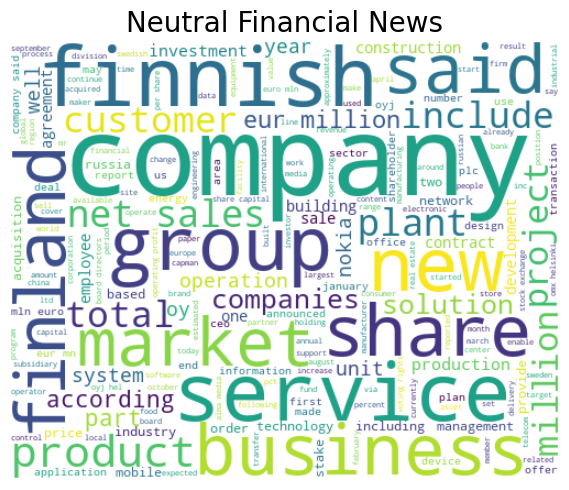


Top 10 words in negative news:
eur: 325
mn: 224
profit: 156
net: 104
company: 100
finnish: 99
sales: 98
operating: 97
period: 88
2009: 85


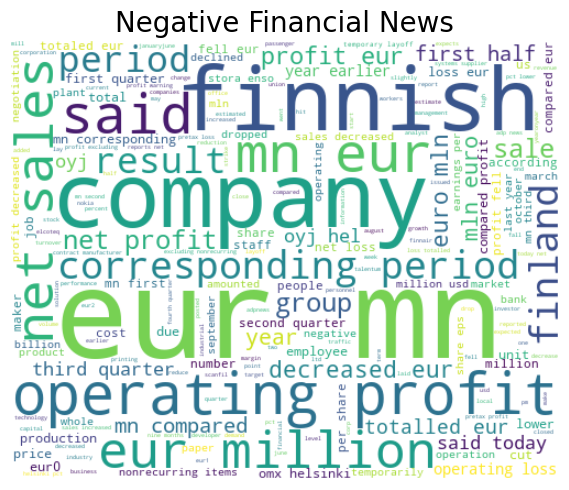


Top 10 words in positive news:
eur: 449
mn: 241
company: 240
said: 230
finnish: 198
net: 196
sales: 192
profit: 191
million: 170
period: 139


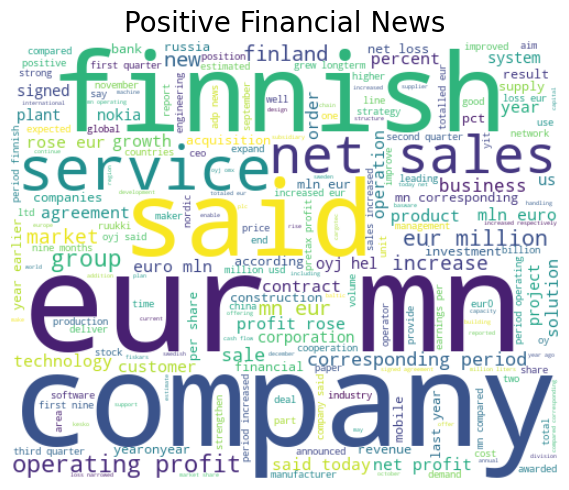

In [70]:
save_as = f"{save_path}/word_cloud_after"
generate_word_cloud_by_sentiment(df=corpora, text_column=clean_column, sentiment_col=sentiment_col, save=True, save_path=save_as)